# 目的
以下を計算する
- mixtral-8x7b-v1.jsonのラベル数

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import ast

import itertools
from collections import Counter

In [2]:
train = pl.read_json("../data/train.json")
mixtral = pl.read_json("../data/mixtral-8x7b-v1.json")

In [3]:
print(train["full_text"][10])

Dear Corrector,

Thank you for taking the time to look through my text. I hope you can find some value in it.

Regards,

Al

My First Mind-Mapping Session

Challenge

A small group of students and I are in the early stages of founding a new student association from the ground up. We noticed that our campus lacks an association that encourages students to take part in cultural activities and that connects art lovers. However, in order to jump start our organization we need events that are actually relevant to our target customers. So we decided to use a design thinking tool to develop design criteria and learn from our stakeholders.

Selection

We selected mind-mapping, a tool that enables the identification of data insights in a collected data set in order to establish criteria for the idea generation phase. (University of Virginia, 2015). This was perfect for us as it allowed us to source our stakeholders needs and understand their expectations better. This tool also allowed us to cou

In [4]:
print(mixtral["full_text"][10])

Andre Sorenson - https://www.twitter.com/sorenson - andresorenson15@mail.com
53092 Alicia Union
West Sandrashire, MS 29843; PIN NUMBER EVpwyzpX4SA1

**Introduction - Identifying the Challenge**

In the dynamic world of tech startups, one of the most significant challenges is crafting innovative marketing strategies that effectively reach target audiences, foster brand loyalty, and drive growth. As a marketing manager at a rapidly growing tech company in Austin, Texas, I faced this very challenge. The increasingly competitive landscape of the tech industry requires businesses to constantly evolve their marketing approach to stand out from the crowd and maintain customer engagement.

**Selection of the Tool or Approach**

To tackle this complex challenge, I decided to apply Blue Ocean Strategy, a business strategy framework developed by W. Chan Kim and Renée Mauborgne. This approach focuses on creating uncontested market space, making the competition irrelevant by reconstructing market b

In [5]:
def count_all_tag(df: pl.DataFrame) -> pl.DataFrame:
    # 全tagのリスト
    all_tags = list(itertools.chain.from_iterable(df.get_column("labels").to_list()))
    all_tags_count = Counter(all_tags)
    return (
        pl.DataFrame(all_tags_count)
        .transpose(include_header=True)
        .rename({"column": "tag", "column_0": "count"})
    ).sort("count", descending=True)


count_all_tag(mixtral)

tag,count
str,i64
"""O""",2011212
"""I-STREET_ADDRE…",19422
"""I-PHONE_NUM""",7974
"""I-NAME_STUDENT…",7459
"""B-NAME_STUDENT…",5937
"""B-URL_PERSONAL…",3297
"""B-EMAIL""",2448
"""B-PHONE_NUM""",2388
"""B-ID_NUM""",2376


In [6]:
import spacy
from spacy.tokens import Span, Doc
from spacy import displacy

# https://matplotlib.org/2.0.2/examples/color/named_colors.html
options = {
    "colors": {
        "B-NAME_STUDENT": "aqua",
        "I-NAME_STUDENT": "aliceblue",
        "B-EMAIL": "forestgreen",
        "I-EMAIL": "greenyellow",
        "B-USERNAME": "hotpink",
        "I-USERNAME": "lightpink",
        "B-ID_NUM": "purple",
        "I-ID_NUM": "rebeccapurple",
        "B-PHONE_NUM": "red",
        "I-PHONE_NUM": "salmon",
        "B-URL_PERSONAL": "slategrey",
        "I-URL_PERSONAL": "silver",
        "B-STREET_ADDRESS": "brown",
        "I-STREET_ADDRESS": "chocolate",
    }
}


class PiiLabelRenderer:
    def __init__(
        self,
        documents: list[str],
        tokens: list[str],
        labels: list[str],
        options: dict[str, dict[str, str]],
    ) -> None:
        self.documents = documents
        self.tokens = tokens
        self.labels = labels
        self.options = options
        self.nlp = spacy.blank("en")

    def render(
        self, render_idx: int | None = None, documents_id: int | None = None
    ) -> None:
        if render_idx and documents_id:
            raise Exception("Don't Use Both render_idx and documents_id")
        if documents_id:
            render_idx = self.documents.index(documents_id)

        doc = Doc(self.nlp.vocab, words=self.tokens[render_idx])
        # エンティティをDocに追加
        ents = []
        start = 0
        label_seq: list[str] = self.labels[render_idx]
        for i, label in enumerate(label_seq):
            if label == "O":
                continue
            ents.append(Span(doc, start=i, end=i + 1, label=label))

        doc.ents = ents

        displacy.render(doc, style="ent", jupyter=True, options=options)

In [7]:
documents = mixtral.get_column("document").to_list()
tokens = mixtral.get_column("tokens").to_list()
full_texts = mixtral.get_column("full_text").to_list()
labels = mixtral.get_column("labels").to_list()

In [8]:
PLR = PiiLabelRenderer(
    documents=documents, tokens=tokens, labels=labels, options=options
)

In [9]:
PLR.render(documents_id="pj_1844")

ValueError: 'pj_1844' is not in list

# テキストの長さは？

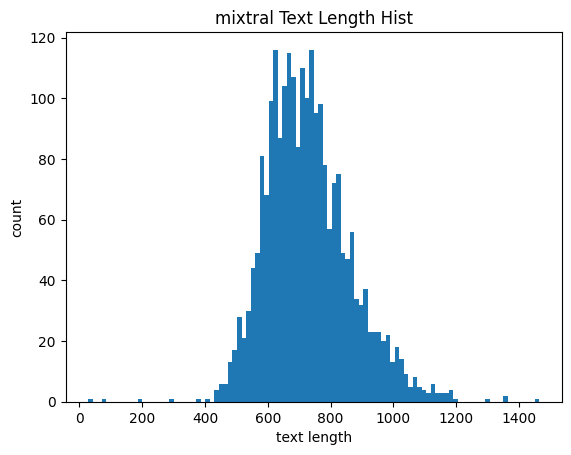

In [43]:
text_len = [len(text.split()) for text in full_texts]
import matplotlib.pyplot as plt

plt.hist(text_len, bins=100)
plt.xlabel("text length")
plt.ylabel("count")
plt.title("mixtral Text Length Hist")